TensorFlow. fashion_mnist.

Построение Multilayer Perceptron (MLP) классификатора

Обучение сети без скрытых слоёв (аналог обычной линейной модели).

Обучение сети с двумя скрытыми слоями по 128 нейронов в каждом. 


Для воспроизводимости кода установим определённую версию TensorFlow и Keras.

In [1]:
#pip install -q tensorflow==2.1

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

2024-12-23 12:19:25.879360: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2024-12-23 12:19:25.879591: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2024-12-23 12:19:25.879611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.1.0
We are using Keras 2.2.4-tf


In [4]:
# Проверяем, что у нас работает GPU
tf.test.gpu_device_name()

2024-12-23 12:19:31.537845: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: FMA
2024-12-23 12:19:31.569707: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2295825000 Hz
2024-12-23 12:19:31.570952: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x622749a0b060 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-12-23 12:19:31.571006: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-12-23 12:19:31.576458: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-12-23 12:19:31.576502: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2024-12-23 12:19:31.576532: I tensorflow/stream_e

''

In [5]:
#GPU count and name
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [6]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## MNIST

In [7]:
# Скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

In [8]:
# Что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


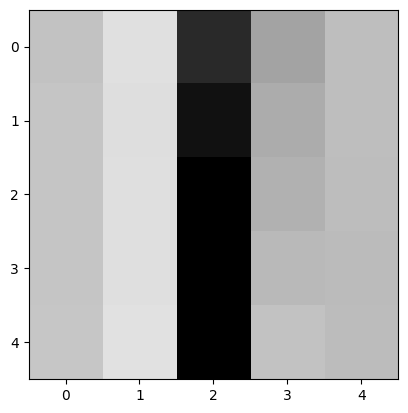

Пример картинки:


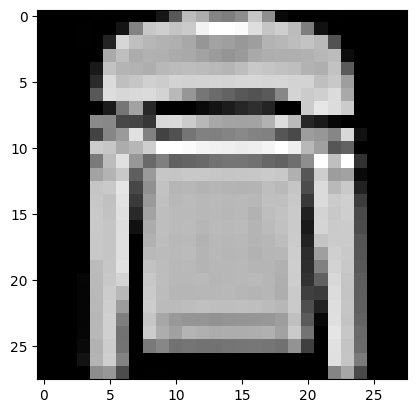

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [9]:
# Нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

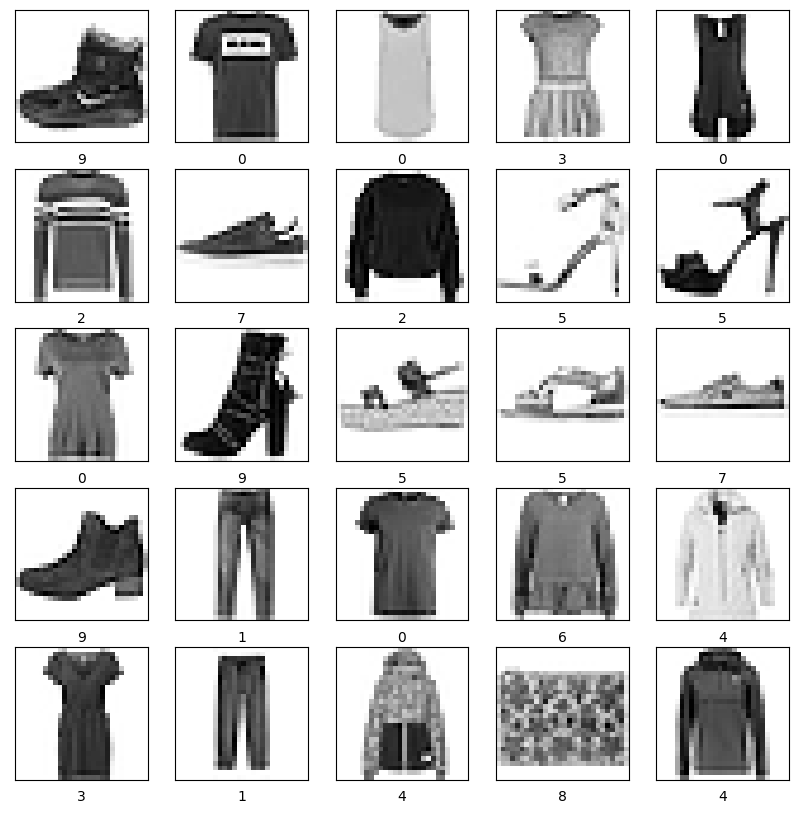

In [10]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

## Data

In [11]:
# Вытянем картинку в вектор размера 28 * 28 = 784 и будем использовать это как фичу!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

# или добавить первый слой - model.add(Flatten())  # Преобразование в одномерный вектор

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [12]:
# Центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(np.float64) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float64) / 255 - 0.5

# По сути, эти действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите, что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

In [13]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


## Собираем модель

Самостоятельно постройте Multilayer Perceptron (MLP) классификатор (по аналогии с практической частью, но на новых данных).

In [14]:
clear_session()

In [15]:
# Здесь ваш код архитектуры сети
# Не забудьте 10 выходов с активацией Softmax на выходном слое!
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [16]:
# или доп слой на невекторизованных данных
#model = Sequential()
#model.add(Flatten())  # Преобразование в одномерный вектор
#model.add(Dense(256, activation='relu', input_shape=(x_train.shape[1],))) # на невекторизованных данных
#model.add(Dense(128, activation='relu'))
#model.add(Dense(10, activation='softmax'))

In [17]:
# Вывод параметров
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаете, что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [19]:
history = model.fit(
                    x_train_float,
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчёта градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_split=0.2
                    )

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 10s 203us/sample - loss: 0.4946 - accuracy: 0.8206 - val_loss: 0.4196 - val_accuracy: 0.8484
Epoch 2/10
48000/48000 [==============================] - 7s 151us/sample - loss: 0.3729 - accuracy: 0.8627 - val_loss: 0.3782 - val_accuracy: 0.8652
Epoch 3/10
48000/48000 [==============================] - 7s 150us/sample - loss: 0.3318 - accuracy: 0.8769 - val_loss: 0.3625 - val_accuracy: 0.8694
Epoch 4/10
48000/48000 [==============================] - 7s 152us/sample - loss: 0.3093 - accuracy: 0.8849 - val_loss: 0.3565 - val_accuracy: 0.8685
Epoch 5/10
48000/48000 [==============================] - 8s 158us/sample - loss: 0.2868 - accuracy: 0.8945 - val_loss: 0.3453 - val_accuracy: 0.8702
Epoch 6/10
48000/48000 [==============================] - 7s 156us/sample - loss: 0.2693 - accuracy: 0.9005 - val_loss: 0.3156 - val_accuracy: 0.8854
Epoch 7/10
48000/48000 [=========================

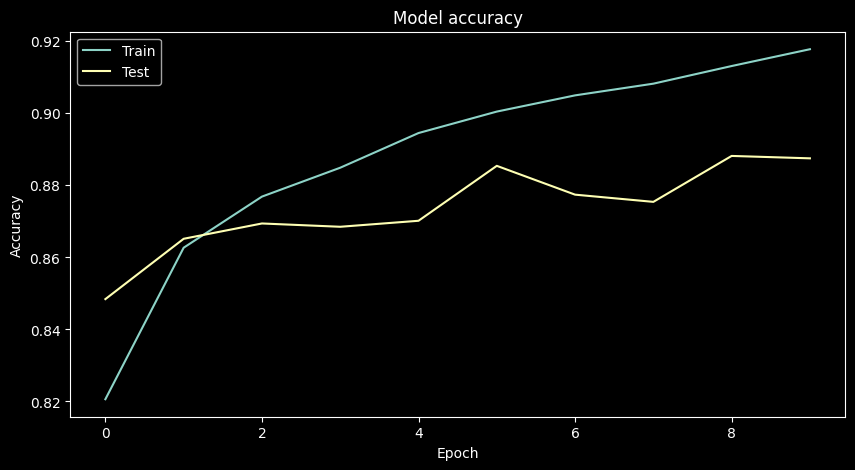

In [20]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

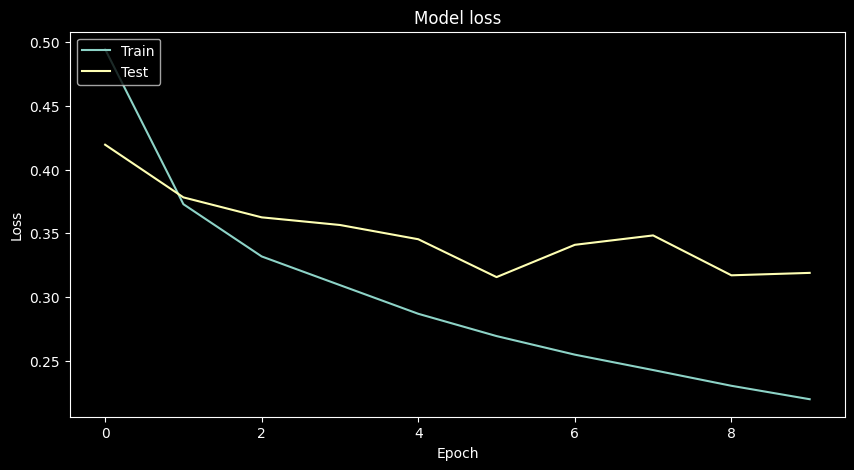

In [21]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
predicts = model.predict_classes(x_val_float)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

Test Accuracy:  0.8823


In [23]:
# Получаем вероятности классов
predictions = model.predict(x_val_float)

# Преобразуем вероятности в классы
predicted_classes = np.argmax(predictions, axis=1)

# Теперь можно вычислить точность
print('Test Accuracy: ', accuracy_score(y_val, predicted_classes))


Test Accuracy:  0.8823


Что вам необходимо сделать:
1. Обучите сеть без скрытых слоёв (постройте аналог обычной линейной модели). **Какое значение accuracy на валидации получили?**
2. Обучите сеть с двумя скрытыми слоями по 128 нейронов в каждом. **Какое значение accuracy на валидации получили?**
3. **Сколько параметров в последней сети?**

Удачи!

## Линейная модель

In [24]:
clear_session()

In [25]:
# Центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(np.float64) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float64) / 255 - 0.5
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

Линейная модель не имеет скрытых слоёв

In [26]:
# Создаем модель
model_linear = keras.Sequential([
    layers.Dense(10, activation='softmax', input_shape=(28 * 28,))  # один слой с 10 нейронами
])

# Компилируем модель
model_linear.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучаем модель
linear_history = model_linear.fit(x_train_float, y_train_oh, epochs=10, batch_size=64, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 4s 79us/sample - loss: 0.6440 - accuracy: 0.7849 - val_loss: 0.5192 - val_accuracy: 0.8177
Epoch 2/10
48000/48000 [==============================] - 3s 67us/sample - loss: 0.4828 - accuracy: 0.8333 - val_loss: 0.4681 - val_accuracy: 0.8352
Epoch 3/10
48000/48000 [==============================] - 3s 69us/sample - loss: 0.4547 - accuracy: 0.8433 - val_loss: 0.4570 - val_accuracy: 0.8438
Epoch 4/10
48000/48000 [==============================] - 3s 68us/sample - loss: 0.4388 - accuracy: 0.8484 - val_loss: 0.4439 - val_accuracy: 0.8445
Epoch 5/10
48000/48000 [==============================] - 3s 67us/sample - loss: 0.4296 - accuracy: 0.8522 - val_loss: 0.4397 - val_accuracy: 0.8456
Epoch 6/10
48000/48000 [==============================] - 3s 72us/sample - loss: 0.4221 - accuracy: 0.8545 - val_loss: 0.4414 - val_accuracy: 0.8429
Epoch 7/10
48000/48000 [==============================] 

In [27]:
# Вывод параметров
model_linear.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


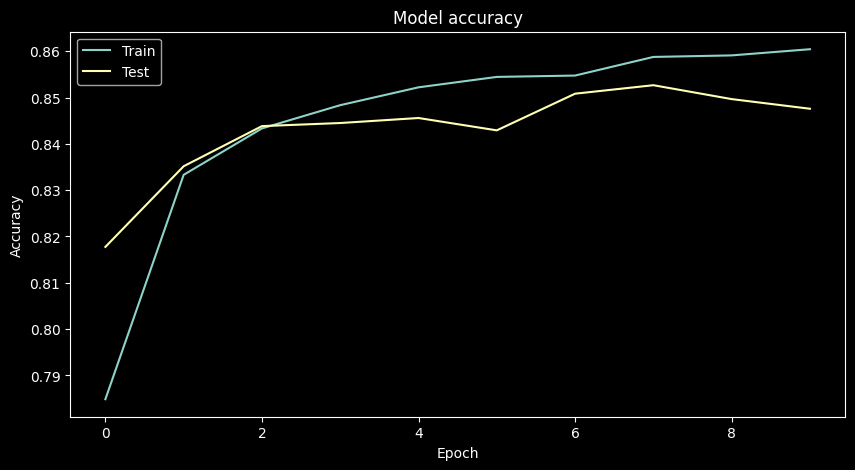

In [28]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(linear_history.history['accuracy'])
plt.plot(linear_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

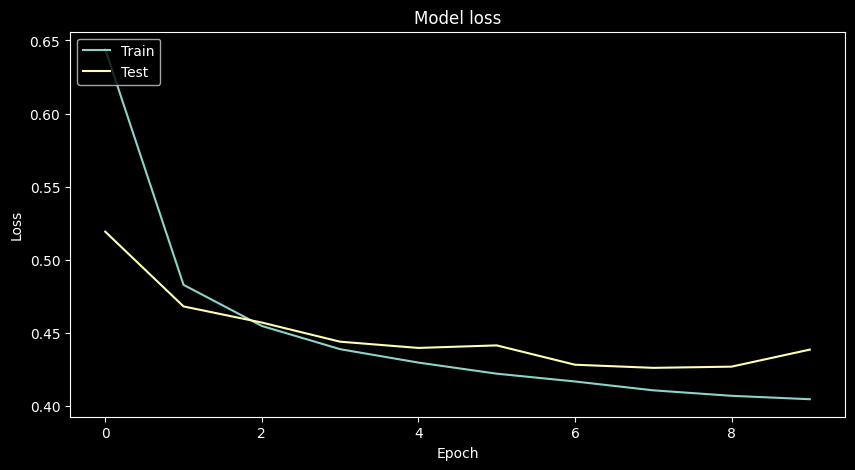

In [29]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(linear_history.history['loss'])
plt.plot(linear_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
# Получаем вероятности классов
predictions_linear = model_linear.predict(x_val_float)

# Преобразуем вероятности в классы
predicted_classes_linear = np.argmax(predictions_linear, axis=1)

# точность
print('Test Accuracy linear: ', accuracy_score(y_val, predicted_classes_linear))

Test Accuracy linear:  0.8378


## Обучите сеть с двумя скрытыми слоями по 128 нейронов в каждом

In [31]:
clear_session()

In [32]:
# Центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(np.float64) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float64) / 255 - 0.5
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

In [33]:
# Создание модели с двумя скрытыми слоями по 128 нейронов
model_two = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(x_train_float.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # Выходной слой с 10 классами
])

# Вывод параметров
model_two.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Компилируем модель
model_two.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучаем модель
two_history = model_two.fit(x_train_float, y_train_oh, epochs=10, batch_size=64, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 6s 126us/sample - loss: 0.5091 - accuracy: 0.8145 - val_loss: 0.4097 - val_accuracy: 0.8475
Epoch 2/10
48000/48000 [==============================] - 5s 104us/sample - loss: 0.3785 - accuracy: 0.8613 - val_loss: 0.3610 - val_accuracy: 0.8684
Epoch 3/10
48000/48000 [==============================] - 5s 107us/sample - loss: 0.3388 - accuracy: 0.8736 - val_loss: 0.3723 - val_accuracy: 0.8608
Epoch 4/10
48000/48000 [==============================] - 6s 115us/sample - loss: 0.3160 - accuracy: 0.8823 - val_loss: 0.3520 - val_accuracy: 0.8732
Epoch 5/10
48000/48000 [==============================] - 5s 105us/sample - loss: 0.2935 - accuracy: 0.8907 - val_loss: 0.3395 - val_accuracy: 0.8770
Epoch 6/10
48000/48000 [==============================] - 5s 107us/sample - loss: 0.2778 - accuracy: 0.8962 - val_loss: 0.3258 - val_accuracy: 0.8790
Epoch 7/10
48000/48000 [==========================

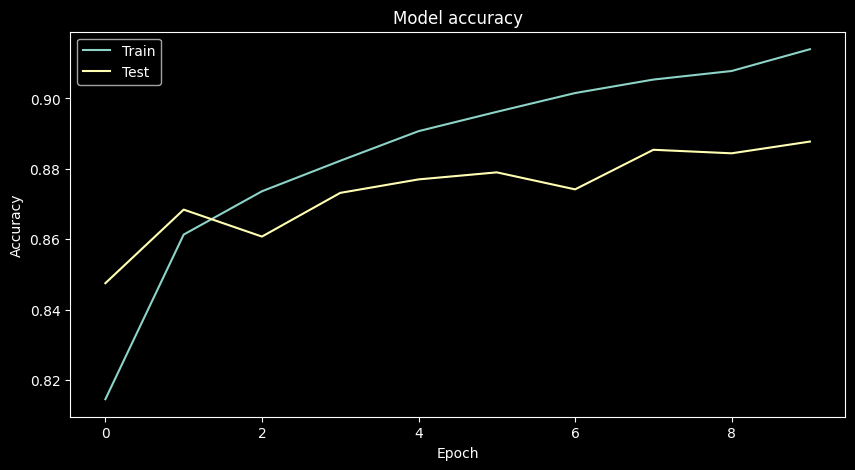

In [35]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(two_history.history['accuracy'])
plt.plot(two_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

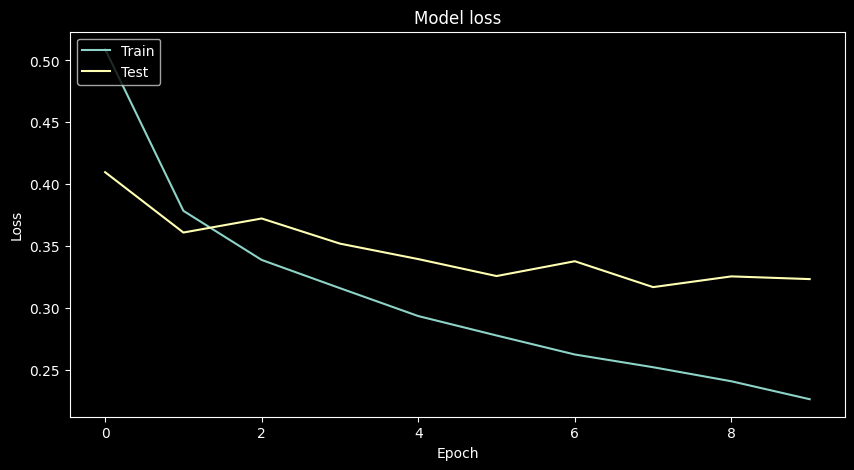

In [36]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(two_history.history['loss'])
plt.plot(two_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
# Получаем вероятности классов
predictions_two = model_two.predict(x_val_float)

# Преобразуем вероятности в классы
predicted_classes_two = np.argmax(predictions_two, axis=1)

# точность
print('Test Accuracy two: ', accuracy_score(y_val, predicted_classes_two))

Test Accuracy two:  0.88


# Выводы:

In [52]:
# models точность
print('Test Accuracy [256, 128]: ', accuracy_score(y_val, predicted_classes))
print('Test Accuracy linear: ', accuracy_score(y_val, predicted_classes_linear))
print('Test Accuracy [128, 128]: ', accuracy_score(y_val, predicted_classes_two))
print('=-*'*10)
print('=-*'*10)
# models history
print('history model [256, 128] accuracy:', history.history['accuracy'])
print('history model [256, 128] val_accuracy:', history.history['val_accuracy'])
print('history model [256, 128] loss:', history.history['loss'])
print('history model [256, 128] val_loss:', history.history['val_loss'])
print('=-*'*10)
print('history model linear accuracy:', linear_history.history['accuracy'])
print('history model linear val_accuracy:', linear_history.history['val_accuracy'])
print('history model linear loss:', linear_history.history['loss'])
print('history model linear val_loss:', linear_history.history['val_loss'])
print('=-*'*10)
print('history model [128, 128] accuracy:', two_history.history['accuracy'])
print('history model [128, 128] val_accuracy:', two_history.history['val_accuracy'])
print('history model [128, 128] loss:', two_history.history['loss'])
print('history model [128, 128] val_loss:', two_history.history['val_loss'])
print('=-*'*10)

Test Accuracy [256, 128]:  0.8823
Test Accuracy linear:  0.8378
Test Accuracy [128, 128]:  0.88
=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*
=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*
history model [256, 128] accuracy: [0.820625, 0.8626875, 0.876875, 0.88489586, 0.8945208, 0.90047914, 0.90497917, 0.9082292, 0.913125, 0.91779166]
history model [256, 128] val_accuracy: [0.8484167, 0.86516666, 0.86941665, 0.8685, 0.87016666, 0.8854167, 0.8774167, 0.8754167, 0.88816667, 0.8875]
history model [256, 128] loss: [0.4945587776899338, 0.37285146512587863, 0.33183568944533665, 0.3093061769406001, 0.2868113558193048, 0.26930314242839815, 0.2547174317936102, 0.2426306202163299, 0.23026814405620097, 0.21971925222873687]
history model [256, 128] val_loss: [0.41958075896898905, 0.37821711055437723, 0.3625403431256612, 0.35653301723798114, 0.3453491761684418, 0.3156110668182373, 0.34096609206994377, 0.34834293389320375, 0.3170190850496292, 0.31892661515871684]
=-*=-*=-*=-*=-*=-*=-*=-*=-*=-*
history model linear accuracy: [0.784

на валидации последней модели получили:

val_accuracy: 0.8846

Количество параметров нейросети

In [59]:
# количество признаков
num_features = x_train_float.shape[1]

# Создание модели с двумя скрытыми слоями по 128 нейронов
model_two = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(num_features,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # Выходной слой с 10 классами
])

# Подсчет количества параметров
P1 = (num_features + 1) * 128  # Первый слой
P2 = (128 + 1) * 128            # Второй слой
P3 = (128 + 1) * 10              # Выходной слой

P_total = P1 + P2 + P3

print(f"Количество параметров нейросети с двумя слоями [128, 128] составляет: {P_total} на количестве признаков: {num_features}")

Количество параметров нейросети с двумя слоями [128, 128] составляет: 118282 на количестве признаков: 784


### Сравнительный анализ обучения моделей TensorFlow по результатам accuracy и history : 

модель с двумя слоями [256, 128],  

простая линейная модель, 

модель с двумя слоями [128, 128]. 

### Выводы

1. **Сравнение тестовой точности**:
   - Модель с двумя скрытыми слоями [256, 128] показала лучшую тестовую точность (88.23%), что указывает на её высокую способность к обобщению.
   - Модель с двумя скрытыми слоями [128, 128] имеет тестовую точность на уровне 88%.
   - Простая линейная модель показала наименьшую тестовую точность (83.78%).
   
- Что подтверждает предположение о том, что более сложные архитектуры лучше справляются с задачами классификации.

2. **Анализ истории обучения**:
   - Модель [256, 128] демонстрирует стабильный рост как в обучающей, так и в валидационной точности на протяжении всех эпох.
   - Простая линейная модель имеет более низкую начальную точность и медленный рост по сравнению с более сложными моделями.
   - Модель [128, 128] также показывает хороший рост в точности и меньшие колебания в валидационной точности по сравнению с простой линейной моделью.

3. **Потери и валидационные потери**:
   - Модель [256, 128] имеет самые низкие значения потерь и валидационных потерь по сравнению с другими моделями.
   - Простая линейная модель имеет наибольшие значения потерь и валидационных потерь на протяжении обучения.
   - Модель [128, 128] показывает умеренные значения потерь между двумя другими моделями.


### Заключение

Более сложные архитектуры с несколькими скрытыми слоями обеспечивают лучшую производительность как по тестовой точности, так и по снижению потерь во время обучения.